# Bitcoin Prices Prediction with Deep Learning/Machine Learning

In [1]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import os
import string
import csv

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime, timedelta

# Model prediction
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend, models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
price_data = pd.read_csv('BTC-USD_05312020.csv', 
                    header = 0, 
                    error_bad_lines=False,
                    engine='python')
                 
price_data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2014-11-20,380.307007,382.024994,356.781006,357.839996,357.839996,25233200
1,2014-11-21,357.878998,357.878998,344.112000,350.847992,350.847992,29850100
2,2014-11-22,351.604004,364.841003,350.877991,352.920013,352.920013,15273000
3,2014-11-23,353.174988,370.845001,353.174988,367.572998,367.572998,15151600
4,2014-11-24,366.947998,387.209015,366.669006,376.901001,376.901001,30930100


In [3]:
price_data.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
2015,2020-05-27,8837.380859,9203.320313,8834.157227,9181.017578,9181.017578,32740536902
2016,2020-05-28,9184.945313,9546.319336,9148.457031,9525.750977,9525.750977,34367073114
2017,2020-05-29,9528.355469,9573.666992,9379.338867,9439.124023,9439.124023,32896642044
2018,2020-05-30,9438.914063,9704.030273,9366.729492,9700.414063,9700.414063,32722975141
2019,2020-05-31,9696.850586,9696.850586,9538.416016,9569.117188,9569.117188,29666250752


## Visualize with scaling the data

In [4]:
signal = np.copy(price_data['Close'].values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
series = pd.Series(std_signal)
series.describe(percentiles = [0.25,0.5,0.75,0.85,0.95])

count    2.020000e+03
mean    -2.978915e-17
std      1.000248e+00
min     -1.005636e+00
25%     -9.396601e-01
50%     -1.837176e-01
75%      8.051709e-01
85%      1.148393e+00
95%      1.639047e+00
max      3.813184e+00
dtype: float64

In [5]:
# visualize with mim max scaler
scaler = MinMaxScaler()
# transform data
minmax = scaler.fit(price_data[['Low', 'Close']])
scaled = minmax.fit_transform(price_data[['Low', 'Close']])

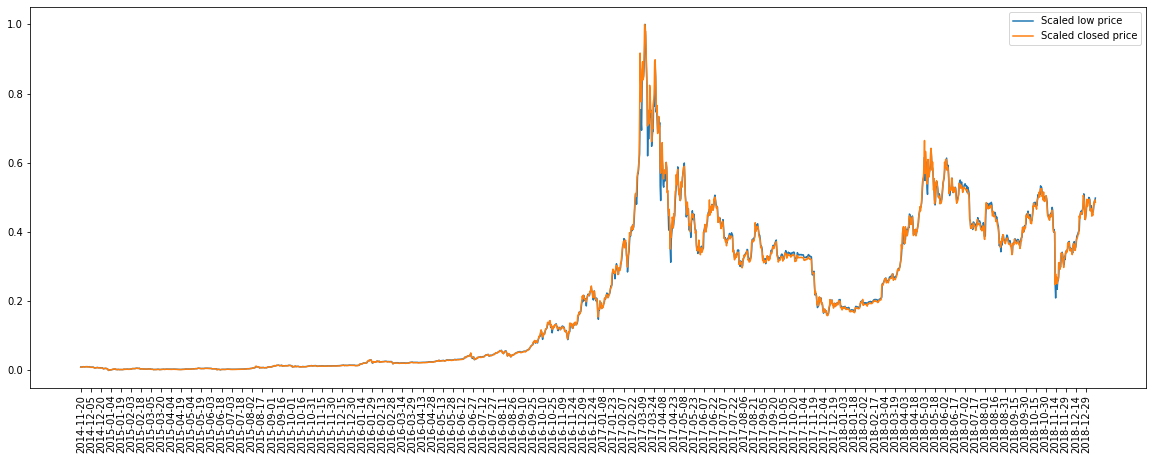

In [6]:
# The time-series can be visualized with the low and Close prices comparison below:

plt.figure(figsize=(20,7))
plt.plot(np.arange(len(signal)), scaled[:,0], label = 'Scaled low price')
plt.plot(np.arange(len(signal)), scaled[:,1], label = 'Scaled closed price')

plt.xticks(np.arange(len(signal))[::20], price_data.Date[::15], rotation='vertical')
plt.legend()
plt.show()

## Training and Testing sets

In [7]:
# Encode the date
price_data['date'] = pd.to_datetime(price_data['Date']).dt.date
group = price_data.groupby('date')

In [8]:
# Split data
prediction_days = 60
Real_Price = group['Close'].mean()
price_train = Real_Price[:len(Real_Price)-prediction_days]
price_test = Real_Price[len(Real_Price)-prediction_days:]

In [9]:
# Process data
training_set = price_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

## Scaling the training set

In [10]:
# Define scaler
scaler = MinMaxScaler()

training_set = scaler.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

## Reshape the train data for the Model

In [11]:
X_train = np.reshape(X_train, (len(X_train), 1, 1))

## Build the Model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


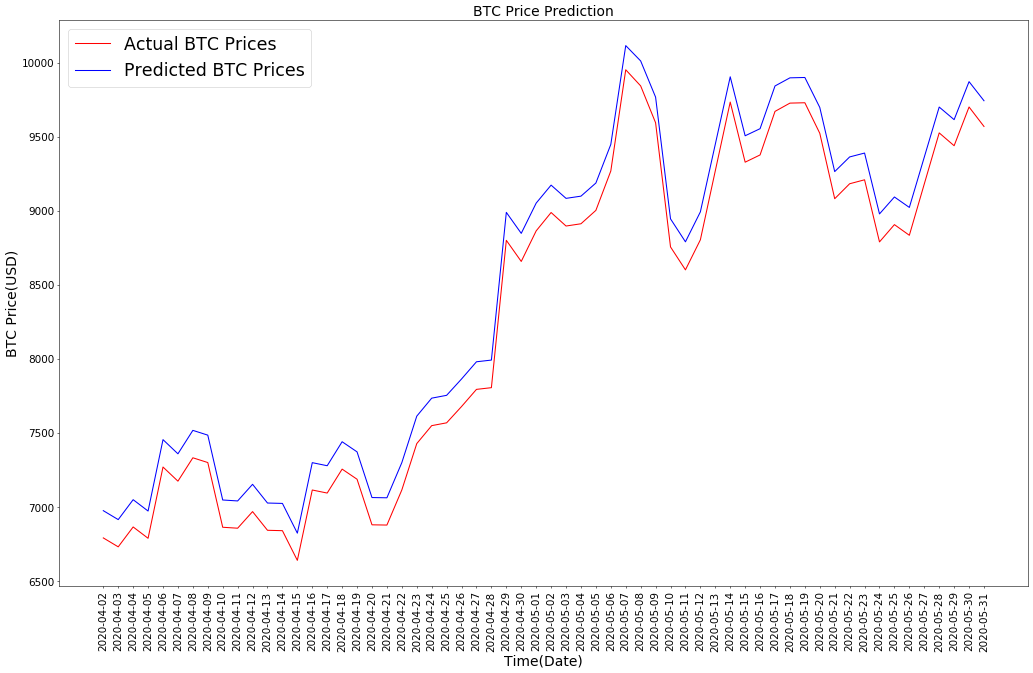

In [12]:
# Build a RNN-LSTM model

backend.clear_session()
model = Sequential()

# Adding the input layer - LSTM layer to create our RNN
model.add(LSTM(units = 100, activation = 'sigmoid', input_shape = (None, 1)))
model.add(layers.Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1, activation='linear'))

# Compiling the model
model.compile(loss = 'mean_squared_error',
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

# Fitting the model to the Training set
model.fit(X_train, y_train, 
          batch_size = 10, 
          epochs = 50, 
          verbose = 0)

# Making the price predictions
test_set = price_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
pred_btc_price = model.predict(inputs)
pred_btc_price_inverse = scaler.inverse_transform(pred_btc_price)

# Visualising the results
plt.figure(figsize = (25,15), dpi=50, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Actual BTC Prices')
plt.plot(pred_btc_price_inverse, color = 'blue', label = 'Predicted BTC Prices')
plt.title('BTC Price Prediction', fontsize=20)
price_test = price_test.reset_index()
x = price_test.index
labels = price_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
plt.xlabel('Time(Date)', fontsize=20)
plt.ylabel('BTC Price(USD)', fontsize=20)
plt.legend(loc=2, prop={'size': 25})
plt.show()